In [79]:
pd.set_option('display.max_colwidth', 100)
from copy import deepcopy
from scipy.stats.mstats import mquantiles
from chase.base import *
from chase.utils import *
from chase.fit import *
from chase.cpt import w_prelec
import itertools

FIGDEST = '/Users/markant/code/chase/chase/paper/results_figures'
TABDEST = '/Users/markant/code/chase/chase/paper/results_tables'
outdir = lambda sim_id: 'results_fits/chase_fitresults_%s' % (sim_id)

# number of iterations for each parameter set
N_ITER = 2

# a list of possible free parameters and their ranges
# and starting point (optional)
PARS = {'theta': [1, 7],
        'p_stay': [0, 1, .5],
        'tau': [0, 1, .5],
        'prelec_gamma': [0, 5, 1.],
        'prelec_elevation': [0, 5, 1.],
        'pow_gain': [0., 5, 1.],
        'w_loss': [0., np.inf, 1.],
        'lambda': [-2, 2, 0.],
        'sc': [0, 1, 1],
        'p_stop': [0, 1, .5]}

PARSETS = {}
PARSETS['optional'] = [['theta', 'p_stay', 'tau'],
                       ['theta', 'p_stay', 'tau', 'prelec_gamma'],
                       ['theta', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation'],
                       ['theta', 'p_stay', 'tau', 'pow_gain'],
                       #['theta', 'p_stay', 'tau', 'pow_gain', 'w_loss'],
                       ]

PARSETS['geometric'] = [['p_stop', 'p_stay', 'tau'],
                        ['p_stop', 'p_stay', 'tau', 'prelec_gamma'],
                        ['p_stop', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation'],
                        ['p_stop', 'p_stay', 'tau', 'pow_gain'],
                        #['theta', 'p_stay', 'tau', 'pow_gain', 'w_loss'],
                        ]

FIXED = {}
for pref_units in ['sums', 'diffs']:
    FIXED[('optional',pref_units)] = {'c': 0.5,
                                      'minsamplesize': 2,
                                      'pref_units': pref_units,
                                      'stoprule': 'optional'}

    FIXED[('geometric',pref_units)] = {'c': 0.5,
                                       'minsamplesize': 2,
                                       'pref_units': pref_units,
                                       'stoprule': 'geometric',
                                       'theta': 30}
    
cp = {}
bf_cp = {}
bf_par = {}
msd_cp = {}
quant = {}
bf_quant = {}

# load the six problems
arr = np.genfromtxt('data/six_problems.csv', delimiter=',')
problems = {i: arr[i].reshape((2,2,2)) for i in range(len(arr))}

# Fit

In [87]:
SIM_ID = 'hertwig2004'
OUTDIR  = outdir(SIM_ID)
data = pd.read_csv('data/hertwig2004/hertwig2004_data.csv', index_col=0)

In [91]:
SIM_ID = 'hau_exp1'
OUTDIR  = outdir(SIM_ID)
data = pd.read_csv('data/hau2008/hau_data.csv', index_col=0)
data = data[data.group==1]

In [115]:
SIM_ID = 'hau_exp2'
OUTDIR  = outdir(SIM_ID)
data = pd.read_csv('data/hau2008/hau_data.csv', index_col=0)
data = data[data.group==2]

In [ ]:
for stoprule, pref_units in itertools.product(['optional', 'geometric'], ['diffs', 'sums']):
    
    print '[%s, %s]\nsaving results to %s' % (stoprule, pref_units, OUTDIR)
    P = PARSETS[stoprule]
    F = FIXED[(stoprule,pref_units)]
    
    if stoprule == 'optional':      model = CHASEModel
    elif stoprule == 'geometric':   model = CHASEAlternateStoppingModel
        
    for parset in P:

        fitting = {p: PARS[p] for p in parset}

        m = model(drift='cpt',
                  startdist='laplace',
                  problems=problems,
                  stoprule=stoprule)

        # fit
        results = fit_mlh(m, problems, data, SIM_ID, F, fitting, 
                          niter=N_ITER, outdir=OUTDIR)

        print results.sort('nllh')

In [ ]:
# create a table summarizing the best-fitting result for each parameter
# combination
allresults = pd.DataFrame(columns=['sim_id', 'stoprule', 'pref_units', 'k', 'N', 'nllh', 'bic'])

for stoprule, pref_units in itertools.product(['optional', 'geometric'], ['diffs', 'sums']):
    
    P = PARSETS[stoprule]
    F = FIXED[(stoprule,pref_units)]
            
    for parset in P:
        fitting = {p: PARS[p] for p in parset}
        b = best_result(SIM_ID, F, fitting, outdir=OUTDIR, nopars=True)
        b['stoprule'] = stoprule
        b['pref_units'] = pref_units
        allresults.loc[allresults.shape[0]] = b

allresults.sort_values(by='bic', inplace=True)
allresults.to_csv('%s/%s_fitsummary.csv' % (TABDEST, SIM_ID))

In [63]:
allresults = pd.read_csv('%s/%s_fitsummary.csv' % (TABDEST, SIM_ID), index_col=0)
allresults

,sim_id,stoprule,pref_units,k,N,nllh,bic
3,"hau_exp2(p_stay,pow_gain,tau,theta|c=0.5,minsamplesize=2,pref_units=diffs,stoprule=optional)",optional,diffs,4.0,234.0,1239.917515,2501.656314
7,"hau_exp2(p_stay,pow_gain,tau,theta|c=0.5,minsamplesize=2,pref_units=sums,stoprule=optional)",optional,sums,4.0,234.0,1240.179707,2502.180698
11,"hau_exp2(p_stay,p_stop,pow_gain,tau|c=0.5,minsamplesize=2,pref_units=diffs,stoprule=geometric,th...",geometric,diffs,4.0,234.0,1241.097100,2504.015484
2,"hau_exp2(p_stay,prelec_elevation,prelec_gamma,tau,theta|c=0.5,minsamplesize=2,pref_units=diffs,s...",optional,diffs,5.0,234.0,1239.194292,2505.665190
4,"hau_exp2(p_stay,tau,theta|c=0.5,minsamplesize=2,pref_units=sums,stoprule=optional)",optional,sums,3.0,234.0,1244.727626,2505.821215
8,"hau_exp2(p_stay,p_stop,tau|c=0.5,minsamplesize=2,pref_units=diffs,stoprule=geometric,theta=30)",geometric,diffs,3.0,234.0,1244.818293,2506.002550
12,"hau_exp2(p_stay,p_stop,tau|c=0.5,minsamplesize=2,pref_units=sums,stoprule=geometric,theta=30)",geometric,sums,3.0,234.0,1244.819248,2506.004459
6,"hau_exp2(p_stay,prelec_elevation,prelec_gamma,tau,theta|c=0.5,minsamplesize=2,pref_units=sums,st...",optional,sums,5.0,234.0,1239.373729,2506.024063
10,"hau_exp2(p_stay,p_stop,prelec_elevation,prelec_gamma,tau|c=0.5,minsamplesize=2,pref_units=diffs,...",geometric,diffs,5.0,234.0,1239.715383,2506.707371
5,"hau_exp2(p_stay,prelec_gamma,tau,theta|c=0.5,minsamplesize=2,pref_units=sums,stoprule=optional)",optional,sums,4.0,234.0,1242.560032,2506.941348


In [116]:
# setup a selected model to show results
OUTDIR  = outdir(SIM_ID)
stoprule = 'optional'
pref_units = 'sums'
parset = PARSETS[stoprule][2]
F = FIXED[(stoprule,pref_units)]
fitting = {p: PARS[p] for p in parset}
r = best_result(SIM_ID, F, fitting, outdir=OUTDIR)
bf_par[SIM_ID] = {p: r[p] for p in fitting}

hau_exp2(p_stay,prelec_elevation,prelec_gamma,tau,theta|c=0.5,minsamplesize=2,pref_units=sums,stoprule=optional)
results_fits/chase_fitresults_hau_exp2/hau_exp2(p_stay,prelec_elevation,prelec_gamma,tau,theta|c=0.5,minsamplesize=2,pref_units=sums,stoprule=optional).csv


In [117]:
# for the selected model, run the model and get the 
# predicted choice proportions and sample size distribution
if stoprule == 'optional':      model = CHASEModel
elif stoprule == 'geometric':   model = CHASEAlternateStoppingModel
m = model(drift='cpt',
          startdist='laplace',
          problems=problems,
          stoprule=stoprule)


#m = CHASEModel(drift='cpt', startdist='laplace')
pred = predict_from_result(m, problems, data, SIM_ID, F, 
                           fitting = fitting, 
                           outdir=OUTDIR)

cp[SIM_ID] = data.groupby('problem').apply(lambda d: np.mean(d.choice))
bf_cp[SIM_ID] = pred.groupby('problem').apply(lambda d: np.mean(d.cp))

quant[SIM_ID] = mquantiles(data.samplesize)
bf_quant[SIM_ID] = pred[['ss(.25)', 'ss(.5)', 'ss(.75)']].mean(axis=0).values

msd_cp[SIM_ID] = np.round(((cp[SIM_ID] - bf_cp[SIM_ID])**2).mean(), 3)
print 'MSD: %s' % msd_cp[SIM_ID]

hau_exp2(p_stay,prelec_elevation,prelec_gamma,tau,theta|c=0.5,minsamplesize=2,pref_units=sums,stoprule=optional)
results_fits/chase_fitresults_hau_exp2/hau_exp2(p_stay,prelec_elevation,prelec_gamma,tau,theta|c=0.5,minsamplesize=2,pref_units=sums,stoprule=optional).csv
MSD: 0.004


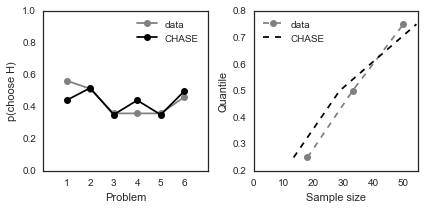

In [118]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
axi = ax[0]
axi.plot(range(1, 7), cp[SIM_ID].values, '-o',
         color='gray', label='data')
axi.plot(range(1, 7), bf_cp[SIM_ID].values, '-o', color='black', label='CHASE')
axi.set_ylim(0, 1)
axi.set_xlim(0, 7)
axi.set_xticks(range(1,7))
axi.set_xlabel('Problem')
axi.set_ylabel('p(choose H)')
axi.legend()

axi = ax[1]
axi.plot(quant[SIM_ID], [.25, .5, .75], '--o', color='gray', label='data')
axi.plot(bf_quant[SIM_ID], [.25, .5, .75], '--x', color='black', label='CHASE')
#axi.set_xlim(0, mq[-1] + 2)
axi.set_xlim(0, 55)
axi.legend(loc='upper left')
axi.set_xlabel('Sample size')
axi.set_ylabel('Quantile')

plt.tight_layout()
plt.show()

# Combine results

In [119]:
studies = ['hertwig2004', 'hau_exp1', 'hau_exp2']
labels = ['HBWE04', 'HPKH08, Exp 1', 'HPKH08, Exp 2']
col = ['red', 'blue', 'purple']

def pars_to_latex(s):
    s = s.replace('|c=0.5,minsamplesize=2', '')
    s = s.replace(',tau,theta', '')
    s = s.replace('p_stay', '$\theta$, $p_{stay}$, $\tau$')
    s = s.replace('pow_gain', ' $\\alpha$')
    s = s.replace('prelec_gamma', ' $\\gamma$')
    s = s.replace('prelec_elevation', ' $\\delta$')
    s = s.replace('w_loss', ' $\\lambda$')
    return s


res = {}
for study in studies:
    res[study] = pd.read_csv('%s/%s_fitsummary.csv' % (TABDEST, study), index_col=0)

models = res['hertwig2004'].sim_id
summed_bic = [np.sum([res[r].loc[i].bic for r in res]) for i in range(len(models))]

arr = []
for i in range(len(models)):
    arr.append([res['hertwig2004'].loc[i].sim_id.lstrip('hertwig2004(').rstrip(')')] + \
               [np.round(res[r].loc[i].bic, 1) for r in studies] + \
               [np.round(np.sum([res[r].loc[i].bic for r in studies]), 1)])

bicdf = pd.DataFrame(arr, columns=['sim_id', 'bic_hertwig2004', 'bic_hau_exp1', 'bic_hau_exp2', 'bic_combined'])
bicdf.sort_values(by='bic_combined', inplace=True)
bicdf.to_csv('%s/bics_combined_6problems.csv' % TABDEST)
bicdf['sim_id'] = map(pars_to_latex, bicdf.sim_id.values)
bicdf.to_latex('%s/bics_combined_6problems.tex' % TABDEST)

In [141]:
bicdf

,sim_id,bic_hertwig2004,bic_hau_exp1,bic_hau_exp2,bic_combined
5,"$\theta$, $p_{stay}$, $\tau$, $\gamma$,pref_units=sums,stoprule=optional",1371.2,1911.7,2506.9,5789.9
6,"$\theta$, $p_{stay}$, $\tau$, $\delta$, $\gamma$,pref_units=sums,stoprule=optional",1376.1,1914.9,2506.0,5797.0
7,"$\theta$, $p_{stay}$, $\tau$, $\alpha$,pref_units=sums,stoprule=optional",1385.9,1908.9,2502.2,5797.0
2,"$\theta$, $p_{stay}$, $\tau$, $\delta$, $\gamma$,pref_units=diffs,stoprule=optional",1379.4,1915.9,2505.7,5800.9
3,"$\theta$, $p_{stay}$, $\tau$, $\alpha$,pref_units=diffs,stoprule=optional",1391.1,1911.0,2501.7,5803.7
13,"$\theta$, $p_{stay}$, $\tau$,p_stop, $\gamma$,tau,pref_units=sums,stoprule=geometric,theta=30",1382.7,1918.6,2507.8,5809.1
14,"$\theta$, $p_{stay}$, $\tau$,p_stop, $\delta$, $\gamma$,tau,pref_units=sums,stoprule=geometric,t...",1387.3,1920.4,2507.6,5815.4
11,"$\theta$, $p_{stay}$, $\tau$,p_stop, $\alpha$,tau,pref_units=diffs,stoprule=geometric,theta=30",1398.6,1913.3,2504.0,5815.9
1,"$\theta$, $p_{stay}$, $\tau$, $\gamma$,pref_units=diffs,stoprule=optional",1378.5,1926.5,2512.4,5817.4
10,"$\theta$, $p_{stay}$, $\tau$,p_stop, $\delta$, $\gamma$,tau,pref_units=diffs,stoprule=geometric,...",1405.3,1919.9,2506.7,5832.0


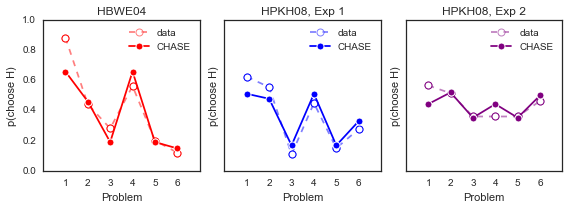

In [125]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3), sharey=True)
for i, study in enumerate(['hertwig2004', 'hau_exp1', 'hau_exp2']):
    axi = ax[i]
    axi.plot(range(1, 7), cp[study], '--o', markerfacecolor='white', markeredgecolor=col[i], 
             markeredgewidth=1, color=col[i], alpha=.5,
             label='data')

    # hacky
    axi.plot(range(1, 7), cp[study], 'o', markerfacecolor='white', markeredgecolor=col[i],
             markeredgewidth=1)


    axi.plot(range(1, 7), bf_cp[study], '-o', markerfacecolor=col[i], markeredgecolor='white', 
             markeredgewidth=1, color=col[i], label='CHASE')
    axi.set_ylim(0, 1)
    axi.set_xlim(0, 7)
    axi.set_xticks(range(1,7))
    axi.set_xlabel('Problem')
    axi.set_ylabel('p(choose H)')
    axi.set_title(labels[i])
    axi.legend()
plt.tight_layout()
plt.show()
fig.savefig('%s/6problems_choiceprop.pdf' % FIGDEST, bbox_inches='tight')

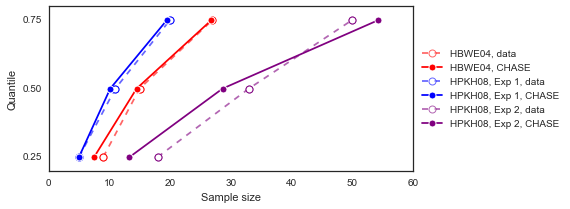

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

axi = ax
for i, study in enumerate(['hertwig2004', 'hau_exp1', 'hau_exp2']):

    axi.plot(quant[study], [.25, .5, .75], '--o', color=col[i],
             markerfacecolor='white', markeredgecolor=col[i], 
             markeredgewidth=1, label='%s, data' % labels[i], alpha=.6)
    
    # hacky
    axi.plot(quant[study], [.25, .5, .75], 'o', color=col[i],
             markerfacecolor='white', markeredgecolor=col[i], markeredgewidth=1)

    axi.plot(bf_quant[study], [.25, .5, .75], '-o', color=col[i], 
             markerfacecolor=col[i], markeredgecolor='white',
             markeredgewidth=1, label='%s, CHASE' % labels[i])

axi.set_xlim(0, 60)
axi.legend(loc='center left', bbox_to_anchor=(1,.5))
axi.set_xlabel('Sample size')
axi.set_ylabel('Quantile')
axi.set_yticks([.25, .5, .75])

plt.tight_layout()
plt.show()
fig.savefig('%s/6problems_quantiles.pdf' % FIGDEST, bbox_inches='tight')

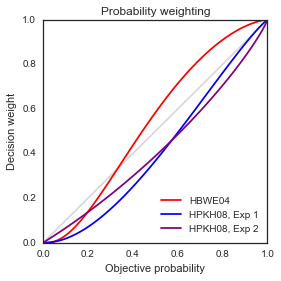

In [146]:
p = np.arange(0, 1.01, .01)
fig, axi = plt.subplots(figsize=(4,4))
axi.plot([0, 1], [0, 1], color='gray', alpha=.3)
for i, sim in enumerate(studies):
    delta = bf_par[sim]['prelec_elevation']
    gamma = bf_par[sim]['prelec_gamma']
    axi.plot(p, w_prelec(p, delta, gamma), '-', label=lab[i], color=col[i])
axi.set_title('Probability weighting')
axi.set_xlabel('Objective probability')
axi.set_ylabel('Decision weight')
axi.legend(loc='lower right')
plt.tight_layout()
plt.show()
fig.savefig('%s/6problems_weighting.pdf' % FIGDEST, bbox_inches='tight')